In [4]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio as rp
import warnings
import orjson as json
warnings.filterwarnings("ignore")

In [5]:
with open('passed.txt') as f:
    tickers = f.read().splitlines()
tickers.append('^TNX')  # 10 year treasury yield
with open('ticker_capm.json') as f:
    ticker_capm = json.loads(f.read())
ticker_info = pd.read_csv('yahoo_tickers.csv')
MAR = 0.13256  # see calc_r.txt

In [6]:
def download_data_and_calc_returns(tickers, period='5y', interval='1d', prepost=False):
    if isinstance(tickers, list):
        data = yf.download(tickers, start='2017-11-30', end='2022-11-30', interval=interval, prepost=prepost, threads=True)
        data = data.loc[:,('Adj Close', slice(None))]  # get adjusted close only
        data.columns = tickers
        data['WYN.L']['2022-06-14'] = 628.0
        data = data[tickers].pct_change().dropna()
        return data
    else:
        data = yf.download(tickers, period=period, interval=interval, prepost=prepost, threads=True)
        data = data.loc[:, 'Adj Close']
        data = data.pct_change().dropna()
        return data

returns = download_data_and_calc_returns(tickers)
returns.index = returns.index.map(lambda a: pd.to_datetime(a).date())  # remove timezone awareness by converting to dates only
returns = returns.sum(level=0)  # merge 2 days into 1 since different market has diff closing time

[*********************100%***********************]  63 of 63 completed


In [7]:
nasdaq_returns = download_data_and_calc_returns('^GSPC', period='10y')
nasdaq_slpm = rp.RiskFunctions.LPM(nasdaq_returns, MAR=MAR/252, p=2)
nasdaq_slpm

[*********************100%***********************]  1 of 1 completed


0.008185501998699303

In [8]:
port = rp.Portfolio(returns=returns, sht=False, lowerret=MAR/252, upperslpm=nasdaq_slpm)

In [9]:
method_to_estimate_expected_return = 'ewma1'  # useless, will be overridden with custom returns
method_to_estimate_covariance = 'hist'
port.assets_stats(method_mu=method_to_estimate_expected_return, method_cov=method_to_estimate_covariance, d=0.99)  # lower d means place more emphasis on recent performance, 0 <= d < 1

In [10]:
port.mu['^TNX'] = 0.04/252  # set risk free asset

In [11]:
def custom_returns(col):
    if col.name != '^TNX':
        return pd.Series([ticker_capm[col.name] / (252*100)])
    else:
        return col
port.mu = port.mu.apply(custom_returns, axis=0)
port.mu*252

,000333.SZ,000858.SZ,300760.SZ,600007.SS,600519.SS,ABT,AFL,ALL,AMD,AMZN,...,TSLA,UAA,ULTA,UNH,VEEV,WDFC,WMT,WSM,WYN.L,^TNX
0,0.075,0.084,0.064,0.08,0.076,0.071,0.08,0.079,0.084,0.089,...,0.085,0.103,0.074,0.069,0.068,0.073,0.076,0.082,0.1,0.04


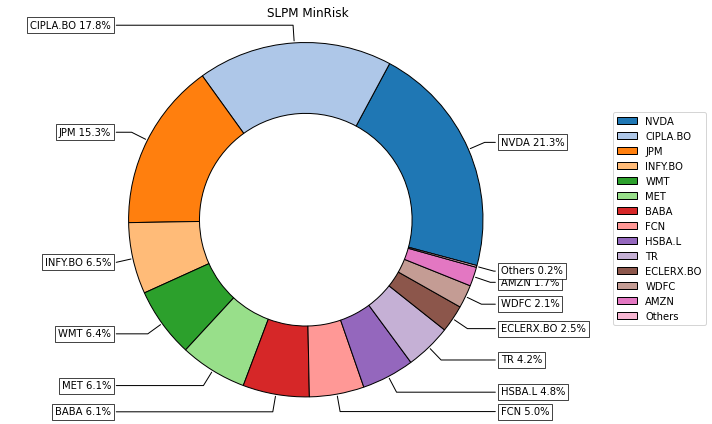

In [12]:
assets = port.mu.columns.values.tolist()

model = 'Classic'  # based on history
risk_measure = 'SLPM'  # Sortino Ratio
obj = 'MinRisk'
risk_free_rate = MAR/252  # MAR converted to daily

#w = port.optimization(model=model, rm=risk_measure, obj=obj, rf=risk_free_rate)
with open('pp.txt') as f:
    weights = f.read().splitlines()
weights = list(map(lambda x: float(x), weights))
weights = [w*1/np.sum(weights) for w in weights]
base = {'tick': assets, 'weights': weights}
w = pd.DataFrame(base).set_index('tick')
ax = rp.plot_pie(w=w, title=f'{risk_measure} {obj}', others=0.01, nrow=len(port.assetslist), cmap="tab20", height=6, width=10, ax=None)

# Marked as markdown as code below are useless
multiplier = [1 for i in range(63)]

#multiplier[port.assetslist.index('CIPLA.BO')] = 0.6
#multiplier[port.assetslist.index('ECLERX.BO')] = 0.5
#multiplier[port.assetslist.index('INFY.BO')] = 0.5
multiplier[port.assetslist.index('NVDA')] = 1.25
multiplier[port.assetslist.index('JPM')] = 1.25
#multiplier[port.assetslist.index('WMT')] = 0.8
#multiplier[port.assetslist.index('MET')] = 0.7
#multiplier[port.assetslist.index('HSBA.L')] = 0.9
#multiplier[port.assetslist.index('BBSE3.SA')] = 0.5


#multiplier[port.assetslist.index('AMZN')] = 1.1
multiplier[port.assetslist.index('TR')] = 0.7
multiplier[port.assetslist.index('NTES')] = 0.5
#multiplier[port.assetslist.index('TCS.BO')] = 0.5
#multiplier[port.assetslist.index('FFH.TO')] = 0.5
#multiplier[port.assetslist.index('SDR.L')] = 0.5
#multiplier[port.assetslist.index('LMT')] = 0.5
#multiplier[port.assetslist.index('WYN.L')] = 0.5

print(multiplier)
port.mu = np.multiply(port.mu, multiplier)
port.mu*252

In [13]:
asset_classes = {'Assets': assets,
                 'Industry': [ticker_info.loc[ticker_info['Ticker'] == ticker]['GICS Sector'].to_list()[0] for ticker in assets[:-1]]+['Treasury'],
                 'Country': [ticker_info.loc[ticker_info['Ticker'] == ticker]['Country'].to_list()[0] for ticker in assets[:-1]]+['NA'],
                 'n': ['Yes' if asset == 'NVDA' else 'No' for asset in assets],
                 'c': ['Yes' if asset == 'CIPLA.BO' else 'No' for asset in assets]}
asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])
asset_classes

,Assets,Industry,Country,n,c
0,000333.SZ,Consumer Discretionary,China,No,No
1,000858.SZ,Consumer Staples,China,No,No
2,300760.SZ,Health Care,China,No,No
3,600007.SS,Real Estate,China,No,No
4,600519.SS,Consumer Staples,China,No,No
...,...,...,...,...,...
58,WDFC,Consumer Staples,US,No,No
59,WMT,Consumer Staples,US,No,No
60,WSM,Consumer Discretionary,US,No,No
61,WYN.L,Consumer Staples,UK,No,No


In [14]:
views = pd.read_csv('views.csv')
views.fillna('', inplace=True)
views

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative
0,,,,,,,,,
1,False,Classes,Industry,Health Care,>=,0.1,Classes,Industry,Industrials
2,False,Classes,Industry,Consumer Staples,>=,0.05,Classes,Industry,Consumer Discretionary
3,False,Classes,Industry,Information Technology,>=,0.1,Classes,Industry,Consumer Staples
4,False,Classes,Country,US,>=,0.1,Classes,Country,India
5,False,Assets,,NVDA,>=,0.2,Classes,Industry,Information Technology
6,False,Assets,,JPM,>=,0.1,Classes,Industry,Financials
7,False,Classes,Country,US,>=,0.5,Classes,Country,Brazil
8,False,Classes,Country,US,>=,0.1,Classes,Country,China
9,False,Classes,Country,US,>=,0.5,Classes,Country,Canada


In [15]:
P, Q = rp.assets_views(views, asset_classes)
pd.DataFrame(P.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000000,-0.1,0.0,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.1,-0.1,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0
2,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.166667,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.1,-0.1,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.000000,0.1,-0.1,0.022222,0.0,0.0,0.022222,0.022222,0.022222,0.022222,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0
59,0.000000,0.1,-0.1,0.022222,0.0,0.0,0.022222,0.022222,0.022222,0.022222,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0
60,0.000000,-0.1,0.0,0.022222,0.0,0.0,0.022222,0.022222,0.022222,0.022222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
61,0.000000,0.1,-0.1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,-0.250000,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0


In [17]:
port.blacklitterman_stats(P, Q/252, rf=risk_free_rate, w=w, delta=None, eq=True)
model='BL'
rm = 'SLPM'
obj = 'MinRisk'
hist = True
w_bl = port.optimization(model=model, rm=rm, obj=obj, rf=risk_free_rate, hist=hist)

def swap_rows(df, i1, i2):
    a, b = df.loc[i1].copy(), df.loc[i2].copy()
    df.loc[i1], df.loc[i2] = b, a
    return df
swap_rows(w_bl, 'WYN.L','NVDA')
swap_rows(w_bl, 'CIPLA.BO','NVDA')
swap_rows(w_bl, 'JPM','FCN')
swap_rows(w_bl, 'WYN.L','WMT')
swap_rows(w_bl, 'TR','FCN')
swap_rows(w_bl, '600519.SS','COST')
w_bl.T

,000333.SZ,000858.SZ,300760.SZ,600007.SS,600519.SS,ABT,AFL,ALL,AMD,AMZN,...,TSLA,UAA,ULTA,UNH,VEEV,WDFC,WMT,WSM,WYN.L,^TNX
weights,0.038566,1.568903e-12,0.053793,0.063023,0.043478,9.582480e-11,8.215913e-13,1.930612e-12,1.444532e-12,1.396778e-11,...,1.046812e-12,4.512947e-13,8.681215e-13,2.573077e-12,0.005734,0.03064,6.562172e-12,9.675934e-13,0.088384,1.224068e-12


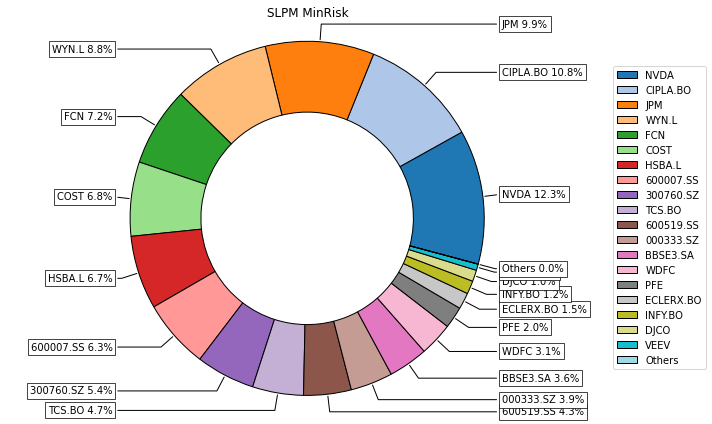

In [23]:
ax = rp.plot_pie(w=w_bl, title=f'{risk_measure} {obj}', others=0.0001, nrow=len(port.assetslist), cmap="tab20", height=6, width=10, ax=None)

array([<AxesSubplot:title={'center':'Copyright (c) 2020-2022, Dany Cajas. All rights reserved.'}>,
       <AxesSubplot:title={'center':'Historical Compounded Cumulative Returns'}>,
       <AxesSubplot:title={'center':'Portfolio Composition'}>,
       <AxesSubplot:title={'center':'Risk (Second Lower Partial Moment) Contribution per Asset'}>,
       <AxesSubplot:title={'center':'Portfolio Returns Histogram'}, ylabel='Probability Density'>,
       <AxesSubplot:title={'center':'Historical Uncompounded Drawdown'}>],
      dtype=object)

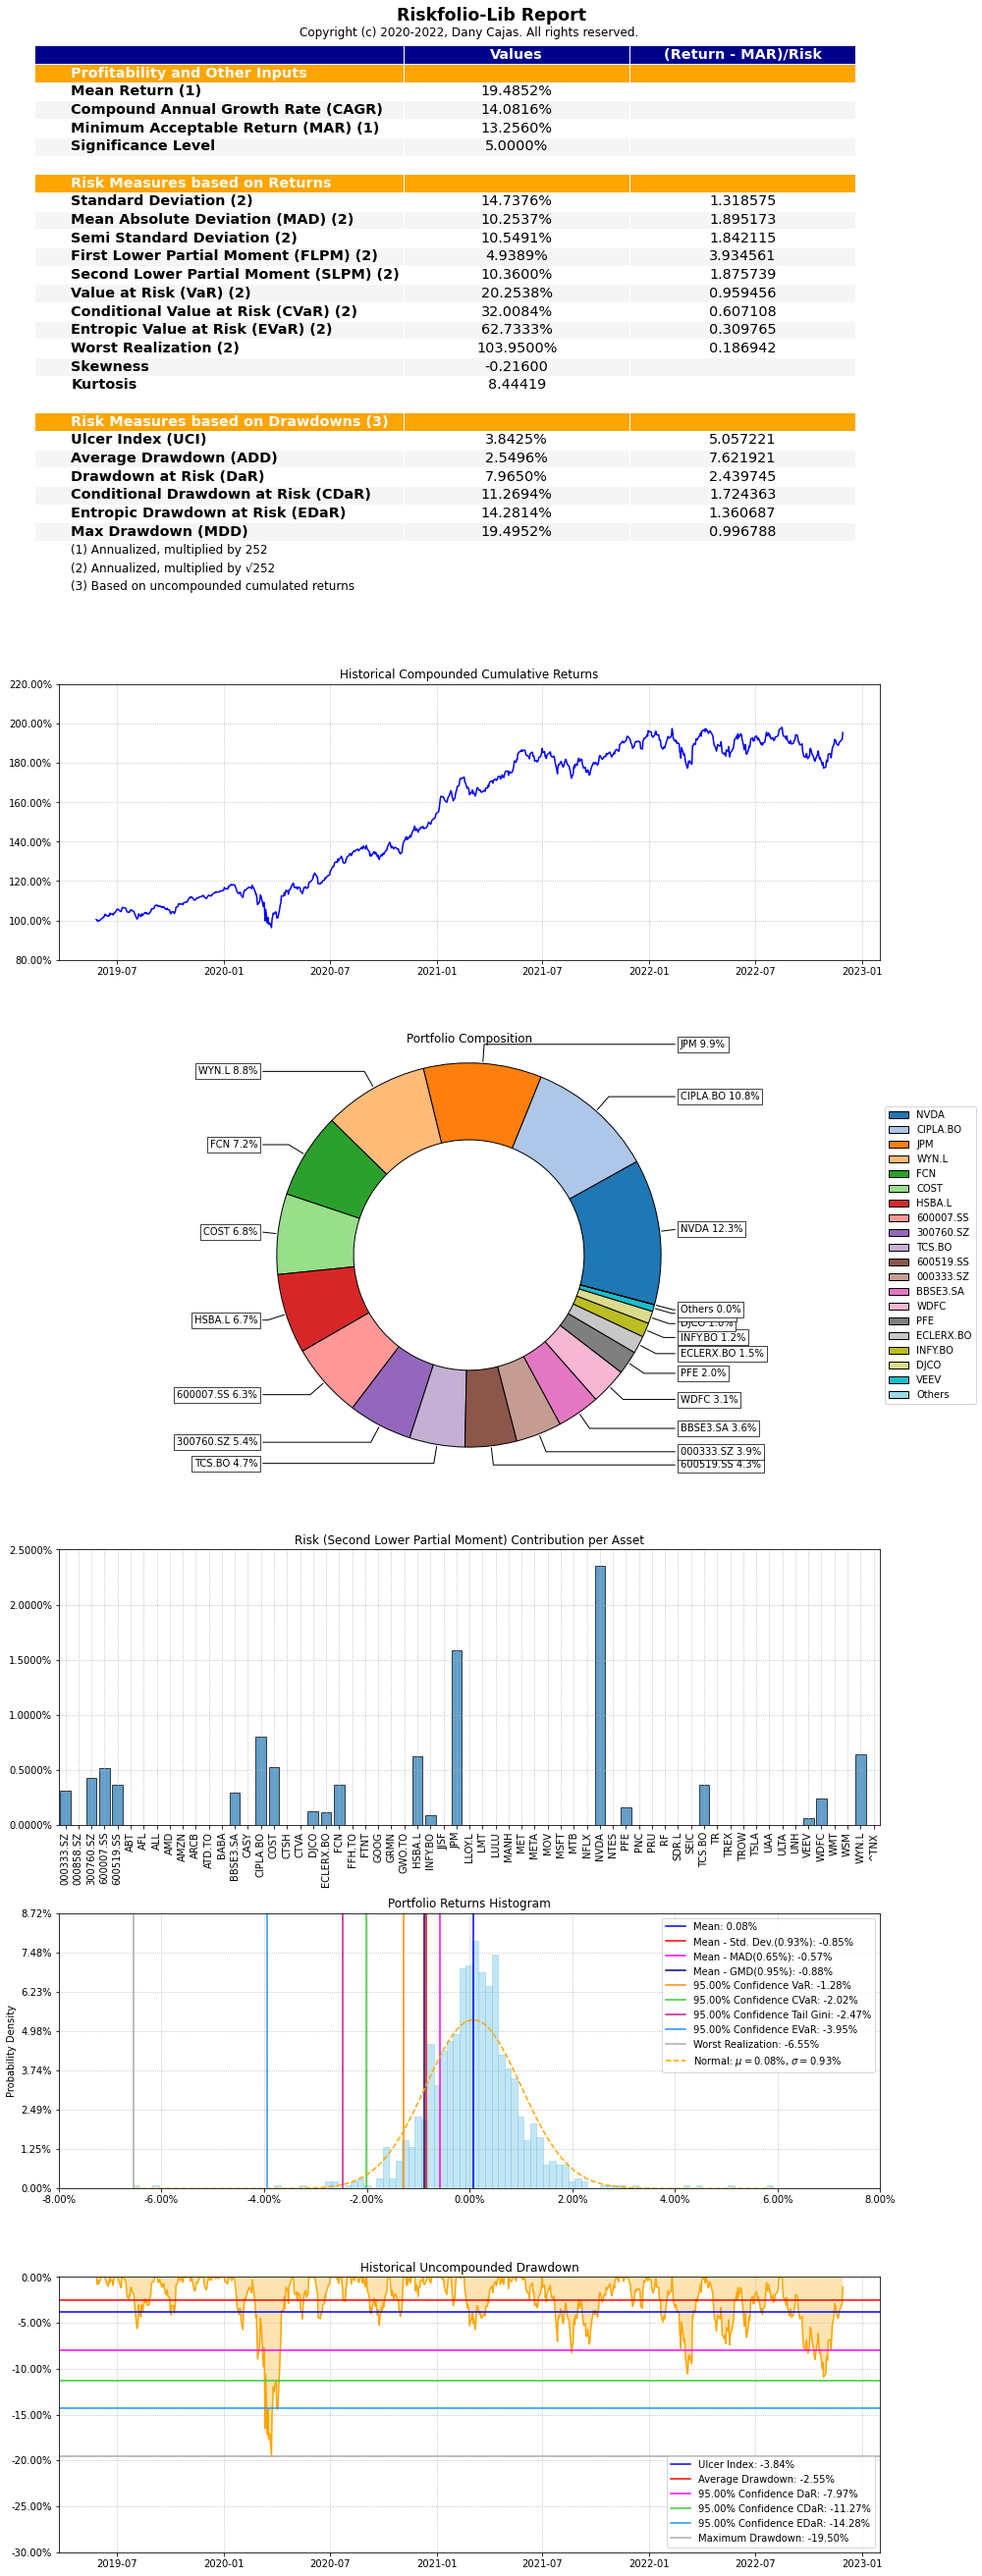

In [24]:
returns.index = returns.index.map(lambda a: pd.to_datetime(a).date())  # remove timezone awareness by converting to dates only
rp.Reports.excel_report(returns, w_bl, rf=risk_free_rate, alpha=0.05, t_factor=252, ini_days=1, days_per_year=252, name='portfolio_report')
rp.Reports.jupyter_report(returns, w_bl, rm=risk_measure, rf=risk_free_rate, alpha=0.05, others=0.00001, nrow=len(port.assetslist), height=6, width=14, t_factor=252, ini_days=1, days_per_year=252, bins=100)

In [25]:
w.round(8)*100

,weights
tick,
000333.SZ,0.000040
000858.SZ,0.000031
300760.SZ,0.161599
600007.SS,0.000028
600519.SS,0.000036
...,...
WDFC,2.113616
WMT,6.359062
WSM,0.000071
